In [122]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc


In [105]:

path = 'loans.csv'
df = pd.read_csv(path)

#Show the head of data set
df.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,-1
1,F,F2,0,5,OWN,5.55,small_business,60 months,1,1,32.6,0.0,-1
2,B,B5,1,1,RENT,18.08,other,60 months,1,1,36.5,0.0,-1
3,C,C1,1,1,RENT,10.08,debt_consolidation,36 months,1,1,91.7,0.0,-1
4,B,B2,0,4,RENT,7.06,other,36 months,1,1,55.5,0.0,-1


In [106]:
#Chech the information from dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46508 entries, 0 to 46507
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   grade                  46508 non-null  object 
 1   sub_grade              46508 non-null  object 
 2   short_emp              46508 non-null  int64  
 3   emp_length_num         46508 non-null  int64  
 4   home_ownership         46508 non-null  object 
 5   dti                    46508 non-null  float64
 6   purpose                46508 non-null  object 
 7   term                   46508 non-null  object 
 8   last_delinq_none       46508 non-null  int64  
 9   last_major_derog_none  46508 non-null  int64  
 10  revol_util             46508 non-null  float64
 11  total_rec_late_fee     46508 non-null  float64
 12  safe_loans             46508 non-null  int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 4.6+ MB


### 只有关于数值型的描述，从均值可以看到平均贷款收入比例约16%，这是比较理性的；但是约87%的人有还款逾期90天以上的记录，说明拖欠还款的情况比较普遍；导致贷款安全比例只到不到0.45%，所以，用未来的钱需要谨慎呐。量入为出，理性消费。

In [107]:
# Check the statistic value 
df.describe()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
count,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000
mean,0.128645,6.343511,16.129507,0.586372,0.874989,55.964813,1.282769,0.004472
std,0.334810,3.750348,7.599843,0.492489,0.330735,25.526221,7.007558,1.000001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,3.000000,10.470000,0.000000,1.000000,37.700000,0.000000,-1.000000
50%,0.000000,6.000000,16.000000,1.000000,1.000000,58.400000,0.000000,1.000000
75%,0.000000,11.000000,21.600000,1.000000,1.000000,76.500000,0.000000,1.000000
max,1.000000,11.000000,38.130000,1.000000,1.000000,150.700000,208.820000,1.000000


In [108]:
# data preprocessing
loans = df.fillna(0)
X = loans.drop(['safe_loans'], axis=1)
Y = loans['safe_loans']
X_dict = X.to_dict(orient='records')
X_dict

[{'grade': 'C',
  'sub_grade': 'C4',
  'short_emp': 1,
  'emp_length_num': 1,
  'home_ownership': 'RENT',
  'dti': 1.0,
  'purpose': 'car',
  'term': ' 60 months',
  'last_delinq_none': 1,
  'last_major_derog_none': 1,
  'revol_util': 9.4,
  'total_rec_late_fee': 0.0},
 {'grade': 'F',
  'sub_grade': 'F2',
  'short_emp': 0,
  'emp_length_num': 5,
  'home_ownership': 'OWN',
  'dti': 5.55,
  'purpose': 'small_business',
  'term': ' 60 months',
  'last_delinq_none': 1,
  'last_major_derog_none': 1,
  'revol_util': 32.6,
  'total_rec_late_fee': 0.0},
 {'grade': 'B',
  'sub_grade': 'B5',
  'short_emp': 1,
  'emp_length_num': 1,
  'home_ownership': 'RENT',
  'dti': 18.08,
  'purpose': 'other',
  'term': ' 60 months',
  'last_delinq_none': 1,
  'last_major_derog_none': 1,
  'revol_util': 36.5,
  'total_rec_late_fee': 0.0},
 {'grade': 'C',
  'sub_grade': 'C1',
  'short_emp': 1,
  'emp_length_num': 1,
  'home_ownership': 'RENT',
  'dti': 10.08,
  'purpose': 'debt_consolidation',
  'term': ' 36 m

### Since there is too many ranka, one-hot encoding can produce a very large number of columns.This works well only if the categorical features have a small number of unique values. Hence, we change it to another way

In [109]:
# Feature engineering(Bad)
vec = DictVectorizer()
X_trans = vec.fit_transform(X_dict)
X_trans = pd.DataFrame(X_trans.toarray())
X_trans.describe()


,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
count,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,...,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000,46508.000000
mean,16.129507,6.343511,0.138084,0.276598,0.252666,0.182313,0.092672,0.045627,0.012041,0.466092,...,0.007397,0.006407,0.004214,0.003053,0.001656,0.001398,0.001720,0.751763,0.248237,1.282769
std,7.599843,3.750348,0.344992,0.447321,0.434546,0.386106,0.289976,0.208676,0.109070,0.498854,...,0.085686,0.079791,0.064782,0.055172,0.040656,0.037359,0.041439,0.431995,0.431995,7.007558
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.470000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,16.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,21.600000,11.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,38.130000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,208.820000


In [110]:
# Feature engineering
# Encoding categorical variables using OneHotEncoder
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Applying OneHotEncoder to categorical features and scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_trans = preprocessor.fit_transform(X)

In [111]:
# Split training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_trans, Y, random_state=1)
X_train.shape
X_test.shape

(11627, 67)

In [112]:
# Using scikit-learn's decision tree model
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, Y_train)


In [113]:
# Test the decision tree model on a specific test sample
test_rec = X_test[1].toarray().reshape(1, -1)
print('Predicted value for the first test sample: ', clf.predict(test_rec))
print('Actual value for the first test sample: ', Y_test.iloc[1])


Predicted value for the first test sample:  [1]
Actual value for the first test sample:  1


In [114]:
# Score the decision tree
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, clf.predict(X_test))


0.6264728648834609

In [115]:
# Using RandomForest for better accuracy
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)
clf = clf.fit(X_train, Y_train)

In [116]:
# Test the RandomForest model on a specific test sample
test_rec = X_test[1].toarray().reshape(1, -1)
print('Predicted value for the first test sample: ', clf.predict(test_rec))
print('Actual value for the first test sample: ', Y_test.iloc[1])


Predicted value for the first test sample:  [1]
Actual value for the first test sample:  1


In [117]:
# Cross-validation for model evaluation
cv_scores = cross_val_score(clf, X_train, Y_train, cv=5)
print('Cross-validation scores: ', cv_scores)
print('Mean cross-validation score: ', np.mean(cv_scores))

Cross-validation scores:  [0.64067651 0.64377867 0.6459289  0.62743693 0.64177179]
Mean cross-validation score:  0.6399185585863381


In [118]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, Y_train)
print('Best parameters from GridSearchCV: ', grid_search.best_params_)


Best parameters from GridSearchCV:  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [119]:
# Score the optimized RandomForest
best_clf = grid_search.best_estimator_
accuracy = accuracy_score(Y_test, best_clf.predict(X_test))
print('Accuracy of the optimized RandomForest: ', accuracy)

### The RandomForest model with hyperparameter tuning has improved the accuracy. Further optimizations could include additional feature engineering (e.g., feature selection, creation of new features), or trying other models such as Gradient Boosting or XGBoost. Cross-validation and hyperparameter tuning are key to ensuring good generalization performance.


Accuracy of the optimized RandomForest:  0.6494366560591727


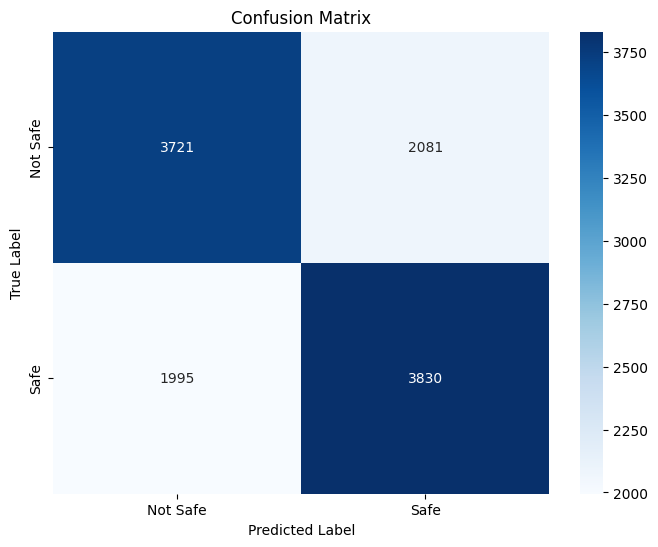

In [123]:
# Visualizing model performance
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, best_clf.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Safe', 'Safe'], yticklabels=['Not Safe', 'Safe'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [124]:
# Classification Report
print('Classification Report:')
print(classification_report(Y_test, best_clf.predict(X_test)))


Classification Report:
              precision    recall  f1-score   support

          -1       0.65      0.64      0.65      5802
           1       0.65      0.66      0.65      5825

    accuracy                           0.65     11627
   macro avg       0.65      0.65      0.65     11627
weighted avg       0.65      0.65      0.65     11627



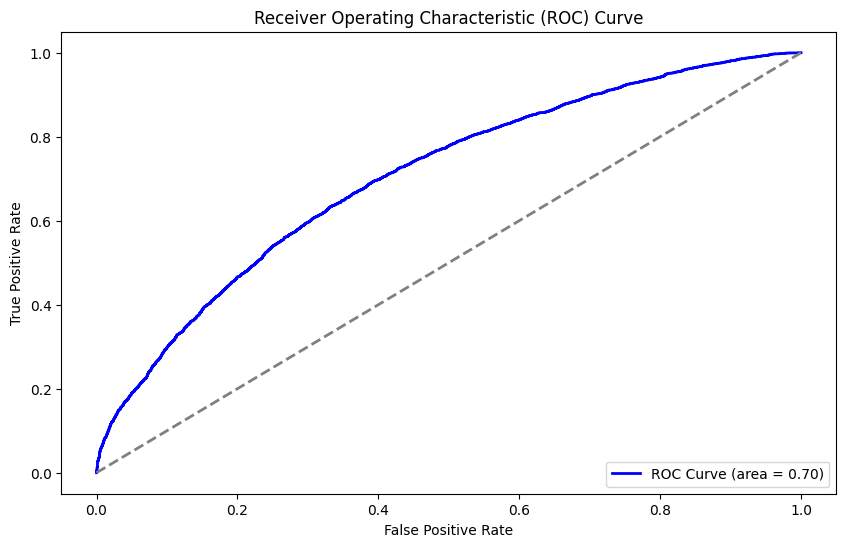

In [126]:
# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, best_clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
